# $Q3$

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader



if (torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Supported Device: {device}")

# Generate XOR dataset
np.random.seed(42)
X = np.random.rand(400, 2)
y = np.logical_xor(X[:, 0] > 0.5, X[:, 1] > 0.5).astype(int)

# Split into training and test sets
X_train, X_test = X[:200], X[200:]
y_train, y_test = y[:200], y[200:]

#Split into train and Val
X_train, X_val = X_train[:150], X_train[150:]
y_train, y_val = y_train[:150], y_train[150:]
print(X_train.shape, y_train.shape)




Supported Device: cpu
(150, 2) (150,)


In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor=torch.from_numpy(X_val).float()
y_val_tensor=torch.from_numpy(y_val).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

In [ ]:

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers = 1):
        super(MLP, self).__init__()
        self.layers = []
        for _ in range(layers):
            self.layers.append(nn.Linear(input_size, hidden_size))
            self.layers.append(nn.Tanh())
            input_size = hidden_size
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = torch.tanh(self.hidden(x))
        x = torch.sigmoid(self.output(x))
        return x

def train(model, X, y, epochs, lr, weight_decay=0, l1_loss = False, l2_loss = False, weight_l1 = 0.01):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for _ in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        if l1_loss:
            loss = criterion(outputs, y) + weight_l1 * torch.sum(torch.abs(model.hidden.weight))
        elif l2_loss:
            loss = criterion(outputs, y) + 0.001 * torch.sum(model.hidden.weight**2)
        else:
            loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_step = epochs/10
        if _ % epoch_step == 0:
          print(f"Epoch [{_ + 1}/{epochs}], Loss: {loss.item():.4f}")


def evaluate(model, X, y):
    outputs = model(X)
    loss = nn.BCELoss()
    loss = loss(outputs, y)
    outputs = (outputs > 0.5).float()
    accuracy = (outputs == y).float().mean()
    return loss.item(), accuracy.item()

In [ ]:


model_mlp = MLP(2, 32, 1)
train(model_mlp, X_train_tensor, y_train_tensor, epochs=100, lr=0.01)
#evaluate the model print the accuracy and test loss


train_loss, train_acc = evaluate(model_mlp, X_train_tensor, y_train_tensor)
val_loss, val_acc = evaluate(model_mlp, X_val_tensor, y_val_tensor)
test_loss, test_acc = evaluate(model_mlp, X_test_tensor, y_test_tensor)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")



Epoch [1/100], Loss: 0.7216
Epoch [11/100], Loss: 0.6896
Epoch [21/100], Loss: 0.6804
Epoch [31/100], Loss: 0.6663
Epoch [41/100], Loss: 0.6278
Epoch [51/100], Loss: 0.5475
Epoch [61/100], Loss: 0.4238
Epoch [71/100], Loss: 0.2894
Epoch [81/100], Loss: 0.1978
Epoch [91/100], Loss: 0.1469
Train Loss: 0.1177, Train Accuracy: 0.9533
Val Loss: 0.1551, Val Accuracy: 0.9400
Test Loss: 0.1610, Test Accuracy: 0.9450


In [ ]:

model_l1 = MLP(2, 32, 1, layers = 2)
train(model_l1, X_train_tensor, y_train_tensor, epochs=3000, lr=0.01, weight_decay=0, l1_loss=True, weight_l1 = 0.001)

train_loss, train_acc = evaluate(model_l1, X_train_tensor, y_train_tensor)
val_loss, val_acc = evaluate(model_l1, X_val_tensor, y_val_tensor)
test_loss, test_acc = evaluate(model_l1, X_test_tensor, y_test_tensor)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch [1/3000], Loss: 0.7876
Epoch [301/3000], Loss: 0.3612
Epoch [601/3000], Loss: 0.1780
Epoch [901/3000], Loss: 0.1500
Epoch [1201/3000], Loss: 0.1357
Epoch [1501/3000], Loss: 0.1255
Epoch [1801/3000], Loss: 0.1178
Epoch [2101/3000], Loss: 0.1114
Epoch [2401/3000], Loss: 0.1064
Epoch [2701/3000], Loss: 0.1026
Train Loss: 0.0540, Train Accuracy: 0.9733
Val Loss: 0.0517, Val Accuracy: 0.9800
Test Loss: 0.0674, Test Accuracy: 0.9800


In [ ]:

model_l2 = MLP(2, 32, 1)
train(model_l2, X_train_tensor, y_train_tensor, epochs=3000, lr=0.005, weight_decay=0.01, l2_loss=True)

train_loss, train_acc = evaluate(model_l2, X_train_tensor, y_train_tensor)
val_loss, val_acc = evaluate(model_l2, X_val_tensor, y_val_tensor)
test_loss, test_acc = evaluate(model_l2, X_test_tensor, y_test_tensor)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch [1/3000], Loss: 0.7035
Epoch [301/3000], Loss: 0.5092
Epoch [601/3000], Loss: 0.2960
Epoch [901/3000], Loss: 0.2918
Epoch [1201/3000], Loss: 0.2893
Epoch [1501/3000], Loss: 0.2894
Epoch [1801/3000], Loss: 0.2894
Epoch [2101/3000], Loss: 0.2894
Epoch [2401/3000], Loss: 0.2894
Epoch [2701/3000], Loss: 0.2894
Train Loss: 0.2707, Train Accuracy: 0.9533
Val Loss: 0.2955, Val Accuracy: 0.9400
Test Loss: 0.3071, Test Accuracy: 0.9400


In [ ]:

X_train_ext = np.c_[X_train[:, 0], X_train[:, 1], X_train[:, 0] * X_train[:, 1], X_train[:, 1]**3, X_train[:, 1]**3]
X_train_ext_tensor = torch.from_numpy(X_train_ext).float()

class model_lr(nn.Module):
    def __init__(self, input_size, output_size):
        super(model_lr, self).__init__()
        self.hidden = nn.Linear(input_size, output_size)

    def forward(self, x):
        return F.sigmoid(self.hidden(x))

logistic_regression = model_lr(5, 1)


train(logistic_regression, X_train_ext_tensor, y_train_tensor, epochs=3000, lr=0.01, l1_loss=True, weight_l1 = 0.001)

X_val_ext = np.c_[X_val[:, 0], X_val[:, 1], X_val[:, 0] * X_val[:, 1], X_val[:, 1]**3, X_val[:, 1]**3]
X_val_ext_tensor = torch.from_numpy(X_val_ext).float()

X_test_ext = np.c_[X_test[:, 0], X_test[:, 1], X_test[:, 0] * X_test[:, 1], X_test[:, 1]**3, X_test[:, 1]**3]
X_test_ext_tensor = torch.from_numpy(X_test_ext).float()

train_loss, train_acc = evaluate(logistic_regression, X_train_ext_tensor, y_train_tensor)
val_loss, val_acc = evaluate(logistic_regression, X_val_ext_tensor, y_val_tensor)
test_loss, test_acc = evaluate(logistic_regression, X_test_ext_tensor, y_test_tensor)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Epoch [1/3000], Loss: 0.7284
Epoch [301/3000], Loss: 0.6170
Epoch [601/3000], Loss: 0.5630
Epoch [901/3000], Loss: 0.5165
Epoch [1201/3000], Loss: 0.4781
Epoch [1501/3000], Loss: 0.4465
Epoch [1801/3000], Loss: 0.4206
Epoch [2101/3000], Loss: 0.3990
Epoch [2401/3000], Loss: 0.3808
Epoch [2701/3000], Loss: 0.3654
Train Loss: 0.3118, Train Accuracy: 0.9667
Val Loss: 0.3317, Val Accuracy: 0.9600
Test Loss: 0.3358, Test Accuracy: 0.9400


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers=1):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(layers):
            self.layers.append(nn.Linear(input_size, hidden_size))
            self.layers.append(nn.Tanh())
            input_size = hidden_size
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = torch.tanh(self.hidden(x))
        x = torch.sigmoid(self.output(x))
        return x

def train(model, X, y, epochs, lr, l1_loss=False, weight_l1=0.01, l2_loss=False, weight_l2=0.01):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        if l1_loss:
            loss += weight_l1 * torch.sum(torch.abs(model.hidden.weight))
        if l2_loss:
            loss += weight_l2 * torch.sum(model.hidden.weight ** 2)
        loss.backward()
        optimizer.step()

        if epoch % (epochs // 10) == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

def evaluate(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        criterion = nn.BCELoss()
        loss = criterion(outputs, y)
        outputs = (outputs > 0.5).float()
        accuracy = (outputs == y).float().mean()
    return loss.item(), accuracy.item()

def tune_regularization_and_train(X_train, y_train, X_val, y_val, hidden_size, layers, learning_rate, regularization_type='l1'):
    best_accuracy = 0
    best_weight = 0

    # Try different values of regularization weight
    for weight in [0.001, 0.01, 0.1]:
        model = MLP(2, hidden_size, 1, layers=layers)
        if regularization_type == 'l1':
            train(model, X_train, y_train, epochs=100, lr=learning_rate, l1_loss=True, weight_l1=weight)
        elif regularization_type == 'l2':
            train(model, X_train, y_train, epochs=100, lr=learning_rate, l2_loss=True, weight_l2=weight)

        _, val_accuracy = evaluate(model, X_val, y_val)

        # Update best accuracy and weight
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_weight = weight

    # Retrain the model using the best weight on the entire training set
    print(f"Best {regularization_type} weight:", best_weight)
    best_model = MLP(2, hidden_size, 1, layers=layers)
    if regularization_type == 'l1':
        train(best_model, X_train, y_train, epochs=500, lr=learning_rate, l1_loss=True, weight_l1=best_weight)
    elif regularization_type == 'l2':
        train(best_model, X_train, y_train, epochs=500, lr=learning_rate, l2_loss=True, weight_l2=best_weight)

    return best_model

# Example usage
best_model_l1 = tune_regularization_and_train(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, hidden_size=32, layers=2, learning_rate=0.01, regularization_type='l1')
best_model_l2 = tune_regularization_and_train(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, hidden_size=32, layers=2, learning_rate=0.01, regularization_type='l2')

train_loss_l1, train_acc_l1 = evaluate(best_model_l1, X_train_tensor, y_train_tensor)
val_loss_l1, val_acc_l1 = evaluate(best_model_l1, X_val_tensor, y_val_tensor)
test_loss_l1, test_acc_l1 = evaluate(best_model_l1, X_test_tensor, y_test_tensor)
print(f"L1 Regularization - Train Loss: {train_loss_l1:.4f}, Train Accuracy: {train_acc_l1:.4f}")
print(f"L1 Regularization - Val Loss: {val_loss_l1:.4f}, Val Accuracy: {val_acc_l1:.4f}")
print(f"L1 Regularization - Test Loss: {test_loss_l1:.4f}, Test Accuracy: {test_acc_l1:.4f}")


train_loss_l2, train_acc_l2 = evaluate(best_model_l2, X_train_tensor, y_train_tensor)
val_loss_l2, val_acc_l2 = evaluate(best_model_l2, X_val_tensor, y_val_tensor)
test_loss_l2, test_acc_l2 = evaluate(best_model_l2, X_test_tensor, y_test_tensor)
print(f"L2 Regularization - Train Loss: {train_loss_l2:.4f}, Train Accuracy: {train_acc_l2:.4f}")
print(f"L2 Regularization - Val Loss: {val_loss_l2:.4f}, Val Accuracy: {val_acc_l2:.4f}")
print(f"L2 Regularization - Test Loss: {test_loss_l2:.4f}, Test Accuracy: {test_acc_l2:.4f}")




Epoch [1/100], Loss: 0.7837
Epoch [11/100], Loss: 0.7057
Epoch [21/100], Loss: 0.5879
Epoch [31/100], Loss: 0.3451
Epoch [41/100], Loss: 0.2906
Epoch [51/100], Loss: 0.1943
Epoch [61/100], Loss: 0.1490
Epoch [71/100], Loss: 0.1263
Epoch [81/100], Loss: 0.1133
Epoch [91/100], Loss: 0.1051
Epoch [1/100], Loss: 1.5914
Epoch [11/100], Loss: 0.9058
Epoch [21/100], Loss: 0.8014
Epoch [31/100], Loss: 0.7384
Epoch [41/100], Loss: 0.6992
Epoch [51/100], Loss: 0.5891
Epoch [61/100], Loss: 0.4065
Epoch [71/100], Loss: 0.3167
Epoch [81/100], Loss: 0.2689
Epoch [91/100], Loss: 0.2392
Epoch [1/100], Loss: 9.5960
Epoch [11/100], Loss: 2.8917
Epoch [21/100], Loss: 1.7880
Epoch [31/100], Loss: 1.1650
Epoch [41/100], Loss: 0.9789
Epoch [51/100], Loss: 0.8782
Epoch [61/100], Loss: 0.8543
Epoch [71/100], Loss: 0.8313
Epoch [81/100], Loss: 0.8190
Epoch [91/100], Loss: 0.8209
Best l1 weight: 0.001
Epoch [1/500], Loss: 0.7837
Epoch [51/500], Loss: 0.1813
Epoch [101/500], Loss: 0.1190
Epoch [151/500], Loss: 0

In [ ]:

h = 0.02
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

models = [model_mlp, model_l1, model_l2, logistic_regression]
model_names = ['MLP', 'MLP with L1', 'MLP with L2', 'Logistic Regression']


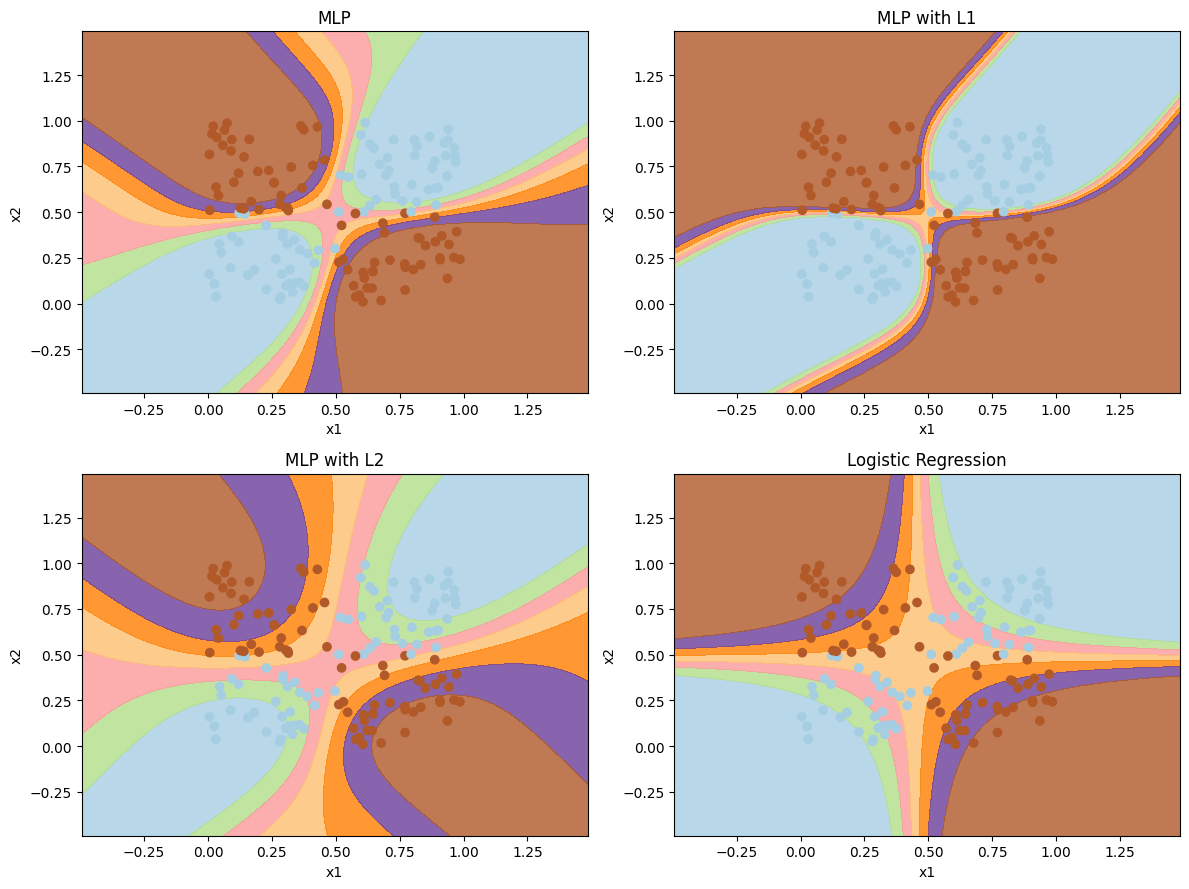

In [ ]:

plt.figure(figsize=(12, 9))
for i, (model, name) in enumerate(zip(models, model_names), 1):
    plt.subplot(2, 2, i)

    model.eval()
    with torch.no_grad():
        if model == logistic_regression:
            Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel(), xx.ravel() * yy.ravel(), np.sin(xx.ravel()), np.sin(yy.ravel())]).float())
        else:
            Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
    Z = Z.numpy().reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(name)

plt.tight_layout()
plt.show()

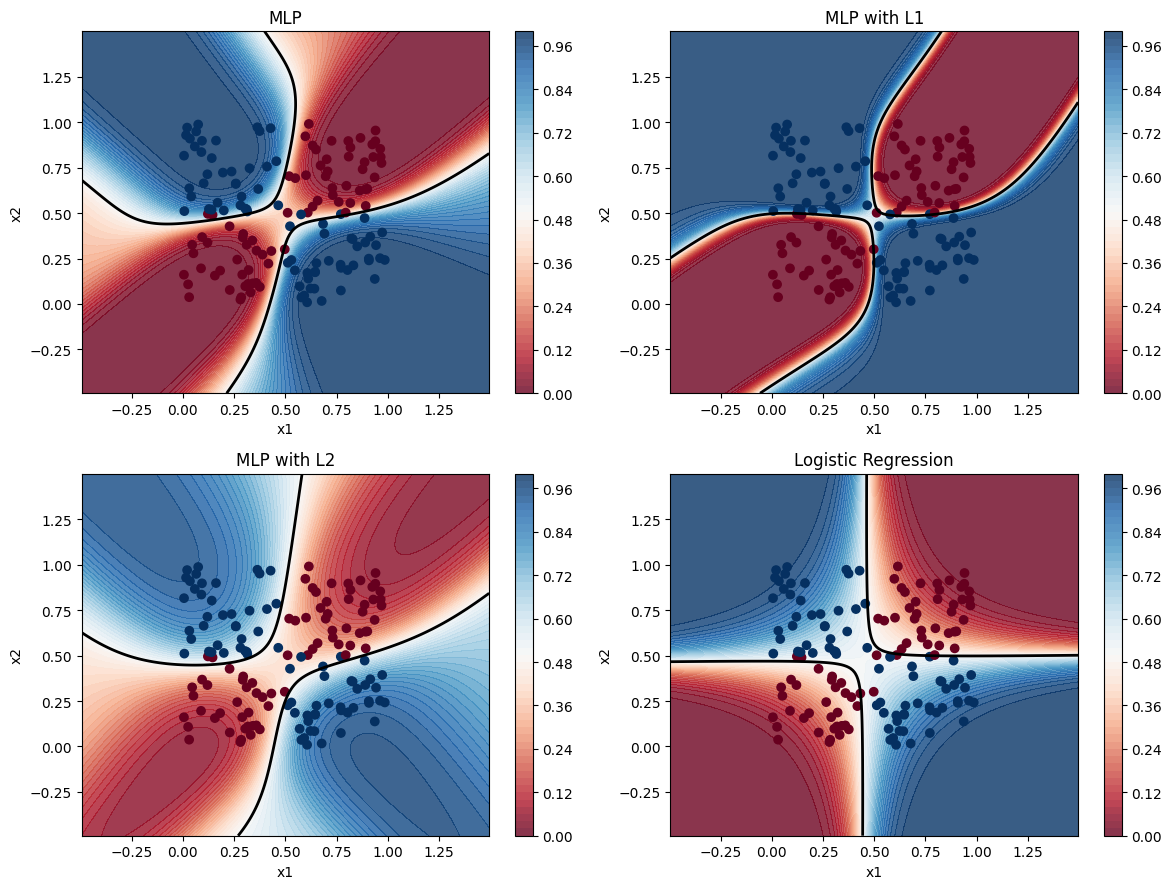

In [ ]:
h = 0.01
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

models = [model_mlp, model_l1, model_l2, logistic_regression]
model_names = ['MLP', 'MLP with L1', 'MLP with L2', 'Logistic Regression']

plt.figure(figsize=(12, 9))
for i, (model, name) in enumerate(zip(models, model_names), 1):
    plt.subplot(2, 2, i)

    model.eval()
    with torch.no_grad():
        if model == logistic_regression:
            Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel(), xx.ravel() * yy.ravel(), xx.ravel()**2, yy.ravel()**2]).float())
        else:
            Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
    Z = Z.numpy().reshape(xx.shape)

    contourf = plt.contourf(xx, yy, Z, levels=np.linspace(0, 1, 51), cmap=plt.cm.RdBu, alpha=0.8)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdBu)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(name)

    # Add colorbar
    plt.colorbar(contourf)

    # Demarcate contour where class is 0 and 1
    plt.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=2)

plt.tight_layout()
plt.show()

MLP (Multi-Layer Perceptron): The MLP plot exhibits a complex decision surface with clearly delineated regions that effectively separate the classes in a non-linear pattern characteristic of the XOR problem. This complexity is possible due to the MLP's layered structure and non-linear activation functions that allow it to model intricate relationships in the data.

MLP with L1 Regularization: The plot for the MLP with L1 regularization shows a decision surface that is simpler than the one produced by the standard MLP. The L1 regularization introduces sparsity in the model's parameters, leading to some of the weights being zeroed. Consequently, this model focuses on the most important features, resulting in a less complex decision boundary that remains effective for the XOR distribution while potentially offering better generalization to unseen data.

MLP with L2 Regularization: In the case of the MLP with L2 regularization, the decision surface is smoother and more regular than that of the L1, reflecting the regularization's tendency to shrink the weights uniformly, rather than pushing them to zero. This type of regularization helps control the model's complexity, penalizing "peaky" weights and therefore reducing overfitting risk. The smoothness of the boundary suggests a balanced approach that mitigates overfitting while still fitting the underlying data structure.

Logistic Regression with Additional Features: The decision surface for logistic regression with engineered features shows that the model is able to capture the XOR problem's non-linearity through feature augmentation. By introducing polynomial features like x1*x2 and x1^2, the linear logistic regression model can fit a curved decision boundary that adapts to the XOR pattern. This plot demonstrates that even a linear model can be made to approximate non-linear boundaries by expanding the feature space with non-linear transformations of the input features.

# $Q4$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

import os
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Warning for future updates in pandas library
try:
    import pyarrow
except ImportError:
    %pip install pyarrow
import pandas as pd

try:
    from statsmodels.tsa.arima.model import ARIMA, ARIMAResultsWrapper
except ImportError:
    %pip install statsmodels
    from statsmodels.tsa.arima.model import ARIMA, ARIMAResultsWrapper

In [4]:
df = pd.read_csv('/content/co2_mm_mlo.csv')
df

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
787,2023,10,2023.7917,418.82,422.12,27,0.47,0.17
788,2023,11,2023.8750,420.46,422.46,21,0.91,0.38
789,2023,12,2023.9583,421.86,422.58,20,0.68,0.29
790,2024,1,2024.0417,422.80,422.45,27,0.73,0.27


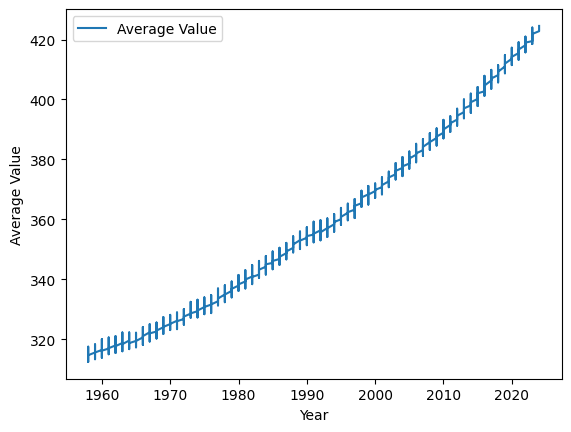

In [ ]:
# @title Average Value Over Time

import matplotlib.pyplot as plt
plt.plot(df['year'], df['average'], label='Average Value')
plt.xlabel('Year')
plt.ylabel('Average Value')
_ = plt.legend()

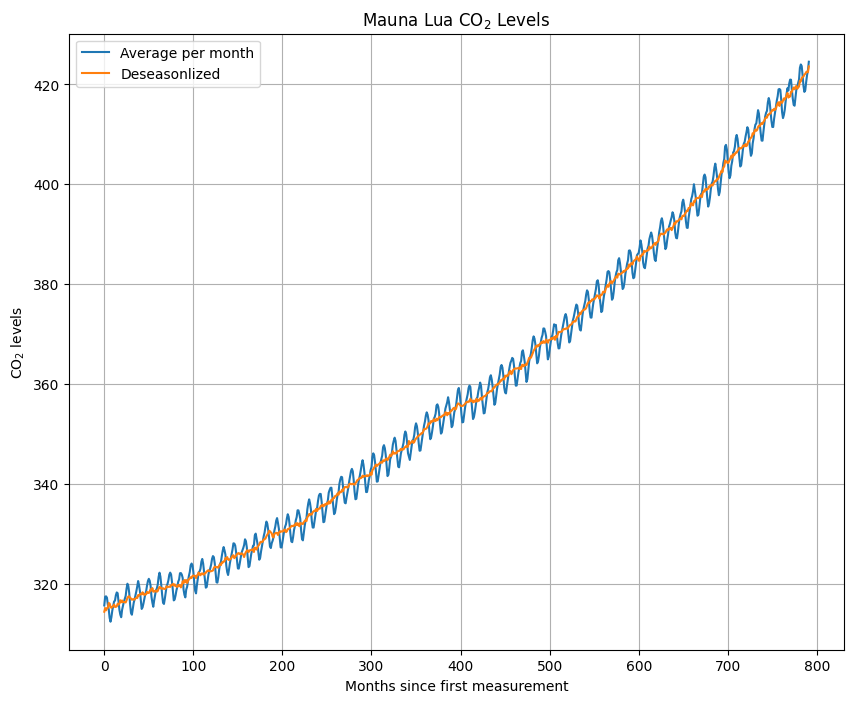

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.title(r'Mauna Lua CO$_2$ Levels')
plt.plot(df.index, df['average'])
plt.plot(df.index, df['deseasonalized'])
plt.xlabel('Months since first measurement')
plt.ylabel(r'CO$_2$ levels')
plt.grid()
plt.legend(['Average per month', 'Deseasonlized'])
plt.show()

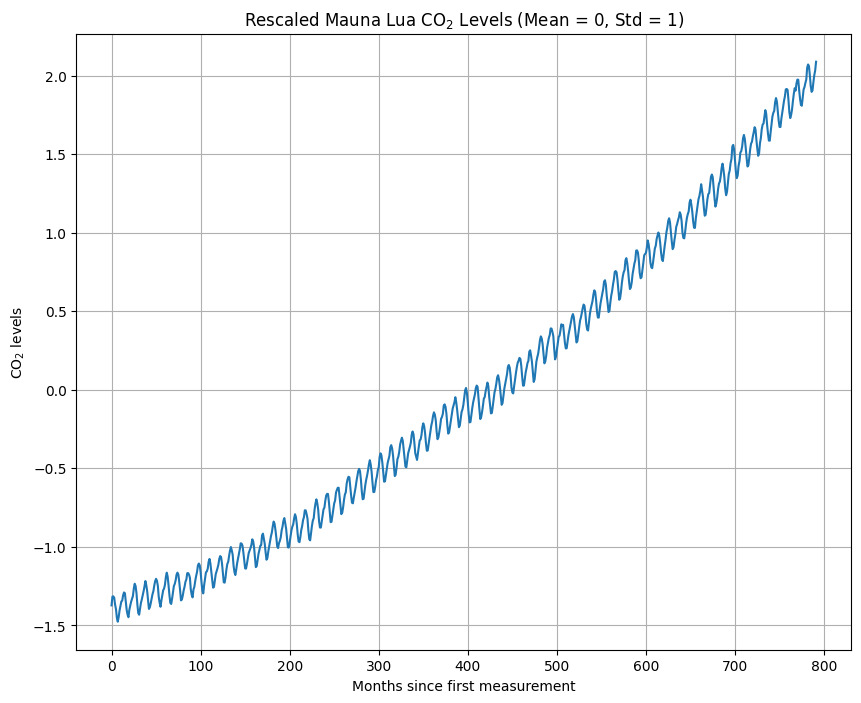

In [ ]:
fig = plt.figure(figsize=(10,8))
scaler = StandardScaler().fit(df['average'].values.reshape(-1,1))
scaled_D = scaler.transform(df['average'].values.reshape(-1,1))
plt.title(r'Rescaled Mauna Lua CO$_2$ Levels (Mean = 0, Std = 1)')
plt.plot(df.index, scaled_D)
plt.xlabel('Months since first measurement')
plt.ylabel(r'CO$_2$ levels')
plt.grid()
plt.show()

In [ ]:
class KTEstimator():
    def __init__(self, data:np.array = scaled_D, K = 3, T = 1, train_size:float = 0.80) -> None:
        self.K = K
        self.T = T
        self.istrained = False

        # Creating Feature - Label Matrix
        D = np.zeros(shape=(len(data)-(self.K+self.T)+1, self.K+self.T))
        for i in range(D.shape[0]):
            D[i] = np.concatenate([data[i:i+self.K,0], data[i+self.K:i+self.K+self.T,0]])

        # Test Train Split
        X_train, X_test, y_train, y_test = D[:int(len(D)*train_size),:self.K], D[int(len(D)*train_size):,:self.K], D[:int(len(D)*train_size),self.K:self.K+self.T], D[int(len(D)*train_size):,self.K:self.K+self.T]
        X_train = torch.tensor(X_train,dtype = torch.float32, device = device, requires_grad=False)
        y_train = torch.tensor(y_train,dtype = torch.float32, device = device, requires_grad=False)
        X_test = torch.tensor(X_test,dtype = torch.float32, device = device, requires_grad=False)
        y_test = torch.tensor(y_test,dtype = torch.float32, device = device, requires_grad=False)

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test

        return None

    def fit(self, model, convergence:float = 1e-8, num_epochs:int = 2000, batch_size:int = 32, lr:float = 0.001):

        # Training the model
        loss_fn = nn.MSELoss()
        opt = torch.optim.Adam(model.parameters(), lr = lr)
        print_every = 100

        dataset = TensorDataset(self.X_train, self.y_train)
        train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        losses = []

        for epoch in range(num_epochs):
            l = 0
            for data, target in train_dataloader:
                opt.zero_grad()
                y_pred = model(data)
                loss = loss_fn(y_pred, target.reshape(-1,self.T))
                l += loss.item()
                loss.backward()
                opt.step()

            losses.append(l/len(self.X_train))

            if epoch != 0 and abs(losses[-1] - losses[-2]) < convergence:
                print(f'Final Training Loss: {losses[-1]}')
                print(f'Converged after {epoch} epochs')
                break

            if epoch % print_every == 0:
                print(f"Epoch: {epoch} | Loss: {losses[-1]}")

        self.train_loss = losses
        self.istrained = True
        return None

    def predict(self, model, seed:int = 42, num_test_cases:int = 5, cumulative:bool = False, pred_len:int = 10):
        loss_fn = nn.MSELoss()
        np.random.seed(seed)

        if self.istrained == False:
            # Untrained Model Prediction
            if cumulative == False:
                with torch.no_grad():
                    test_indices = np.random.randint(0, len(self.X_test), size = num_test_cases)
                    for i in test_indices:
                        y = model(self.X_test[i])
                        loss = loss_fn(y, self.y_test[i])
                        plt.title(f'Extrapolation\nUntrained Model Prediction on Test Data\nTest Index: {i} | MSE: {loss}')
                        plt.plot(np.arange(i+len(self.X_train),i+len(self.X_train)+self.K,1), self.X_test[i], 'bo-')
                        plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), self.y_test[i].detach().numpy(), 'go-')
                        plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), y.detach().numpy(), 'ro-')
                        plt.legend(['Input','Ground Truth','Predicted'])
                        plt.xlabel('Months since first measurement')
                        plt.ylabel(r'Normalized CO$_2$ levels')
                        plt.grid()
                        plt.show()
            else:
                if self.K + pred_len > len(self.X_test):
                    print(f'Sum of input feature length: {self.K} and output predicted length {pred_len} greater test size: {len(self.X_test)}')
                else:
                    test_index = np.random.randint(0, len(self.X_test)-(self.K+pred_len))
                    y = torch.zeros(pred_len, dtype=torch.float16, device=device, requires_grad=False)
                    for i in range(pred_len):
                        if i:
                            y[i] = model(torch.concat((self.X_test[test_index+i, 0:self.K-i], y[0:i])))
                        else:
                            y[i] = model(self.X_test[test_index+i, 0:self.K])
                    loss = loss_fn(y.view(-1,1), self.y_test[test_index: test_index + pred_len])
                    plt.title(f'Cumulative Extrapolation\nUntrained Model Prediction on Test Data\nTest Index: {test_index} | MSE: {loss}')
                    plt.plot(np.arange(test_index+len(self.X_train),test_index+len(self.X_train)+self.K,1), self.X_test[test_index], 'bo-')
                    plt.plot(np.arange(test_index+len(self.X_train)+self.K,test_index+len(self.X_train)+self.K+pred_len,1), self.y_test[test_index:test_index + pred_len].detach().numpy(), 'go-')
                    plt.plot(np.arange(test_index+len(self.X_train)+self.K,test_index+len(self.X_train)+self.K+pred_len,1), y.detach().numpy(), 'ro-')
                    plt.legend(['Input','Ground Truth','Predicted'])
                    plt.xlabel('Months since first measurement')
                    plt.ylabel(r'Normalized CO$_2$ levels')
                    plt.grid()
                    plt.show()
        else:
            # Trained Model Prediction
            if cumulative == False:
                with torch.no_grad():
                    test_indices = np.random.randint(0, len(self.X_test), size = num_test_cases)
                    for i in test_indices:
                        y = model(self.X_test[i])
                        loss = loss_fn(y, self.y_test[i])
                        plt.title(f'Extrapolation\nTrained Model Prediction on Test Data\nTest Index: {i} | MSE: {loss}')
                        plt.plot(np.arange(i+len(self.X_train),i+len(self.X_train)+self.K,1), self.X_test[i], 'bo-')
                        plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), self.y_test[i].detach().numpy(), 'go-')
                        plt.plot(np.arange(i+len(self.X_train)+self.K,i+len(self.X_train)+self.K+self.T,1), y.detach().numpy(), 'ro-')
                        plt.legend(['Input','Ground Truth','Predicted'])
                        plt.xlabel('Months since first measurement')
                        plt.ylabel(r'Normalized CO$_2$ levels')
                        plt.grid()
                        plt.show()
            else:
                if self.K + pred_len > len(self.X_test):
                    print(f'Sum of input feature length: {self.K} and output predicted length {pred_len} greater test size: {len(self.X_test)}')
                else:
                    test_index = np.random.randint(0, len(self.X_test)-(self.K+pred_len))
                    y = torch.zeros(pred_len, dtype=torch.float16, device=device, requires_grad=False)
                    for i in range(pred_len):
                        if i:
                            y[i] = model(torch.concat((self.X_test[test_index+i, 0:self.K-i], y[0:i])))
                        else:
                            y[i] = model(self.X_test[test_index+i, 0:self.K])
                    loss = loss_fn(y.view(-1,1), self.y_test[test_index:test_index + pred_len])
                    plt.title(f'Cumulative Extrapolation\nTrained Model Prediction on Test Data\nTest Index: {test_index} | MSE: {loss}')
                    plt.plot(np.arange(test_index+len(self.X_train),test_index+len(self.X_train)+self.K,1), self.X_test[test_index], 'bo-')
                    plt.plot(np.arange(test_index+len(self.X_train)+self.K,test_index+len(self.X_train)+self.K+pred_len,1), self.y_test[test_index:test_index + pred_len].detach().numpy(), 'go-')
                    plt.plot(np.arange(test_index+len(self.X_train)+self.K,test_index+len(self.X_train)+self.K+pred_len,1), y.detach().numpy(), 'ro-')
                    plt.legend(['Input','Ground Truth','Predicted'])
                    plt.xlabel('Months since first measurement')
                    plt.ylabel(r'Normalized CO$_2$ levels')
                    plt.grid()
                    plt.show()
                    return test_index
        return None

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_size1, hidden_size2, output_dim):
    super(MLP, self).__init__()
    self.lin1 = nn.Linear(input_dim, hidden_size1)
    self.lin2 = nn.Linear(hidden_size1, hidden_size2)
    self.lin3 = nn.Linear(hidden_size2, output_dim)

  def forward(self, x):
    y1 = self.lin1(x)
    y2 = torch.relu(y1)
    y3 = self.lin2(y2)
    y4 = torch.relu(y3)
    y = self.lin3(y4)
    return y

In [ ]:
K = 30
T = 10

hidden_size1 = 20
hidden_size2 = 15

model = MLP(input_dim = K, hidden_size1 = hidden_size1 , hidden_size2 = hidden_size2, output_dim = T)

Epoch: 0 | Loss: 0.006743274276389236
Epoch: 100 | Loss: 1.5873107349459836e-05
Final Training Loss: 1.4132612185286625e-05
Converged after 109 epochs


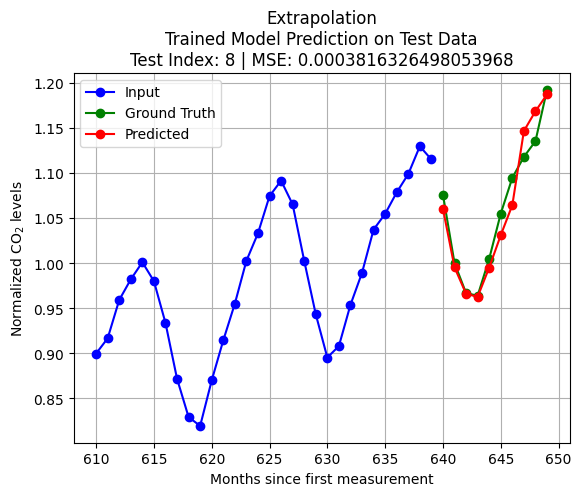

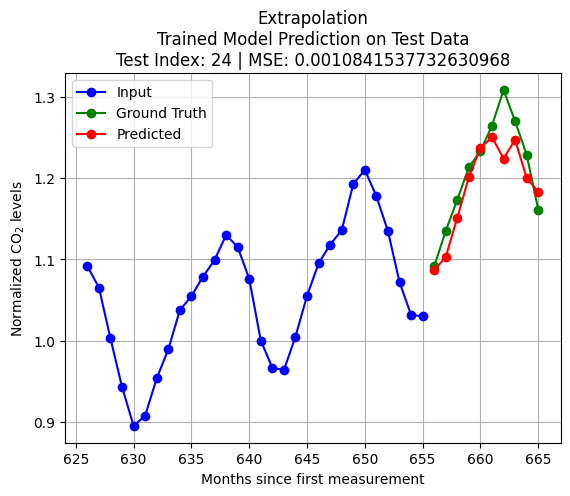

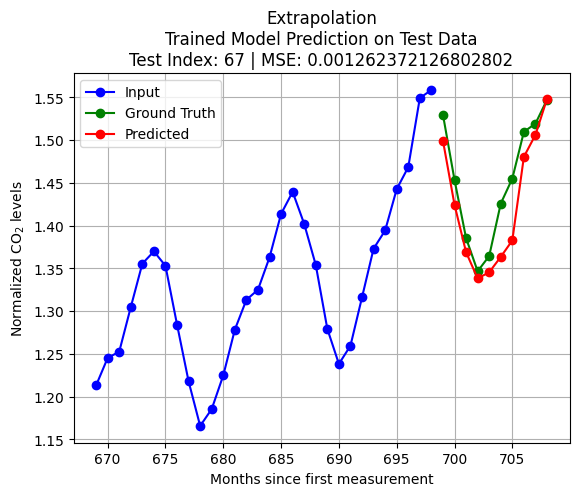

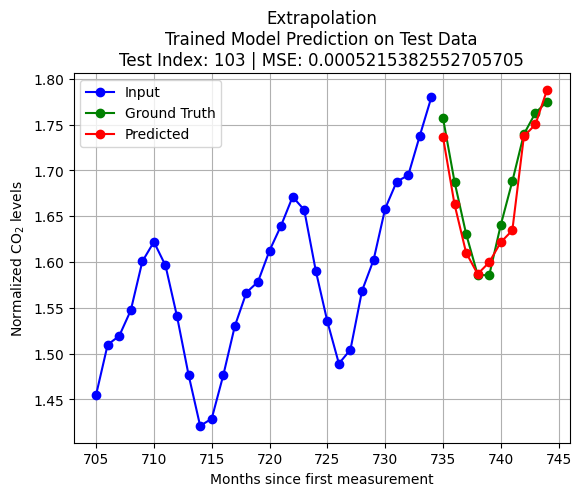

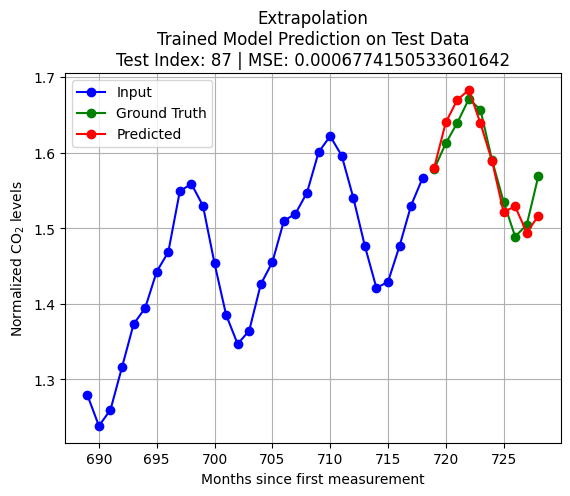

In [ ]:
train_size = 0.8
est = KTEstimator(scaled_D, K, T, train_size)
seed = 53
num_test_cases = 5

# Untrained Model Prediction
# est.predict(model, seed, num_test_cases, cumulative = False)


convergence = 1e-8
num_epochs = 2000
batch_size = 32
lr = 0.01
#Trained Model Prediction
est.fit(model, convergence, num_epochs, batch_size, lr)
est.predict(model, 100, 5, cumulative  = False)

In [ ]:
K = 30
T = 1
hidden_size1 = 20
hidden_size2 = 15

model = MLP(input_dim = K, hidden_size1 = hidden_size1 , hidden_size2 = hidden_size2, output_dim = T)

Epoch: 0 | Loss: 0.005401456438017205
Epoch: 100 | Loss: 8.1218911272937e-05
Epoch: 200 | Loss: 1.1944086763056603e-05
Final Training Loss: 1.1952598564174219e-05
Converged after 201 epochs


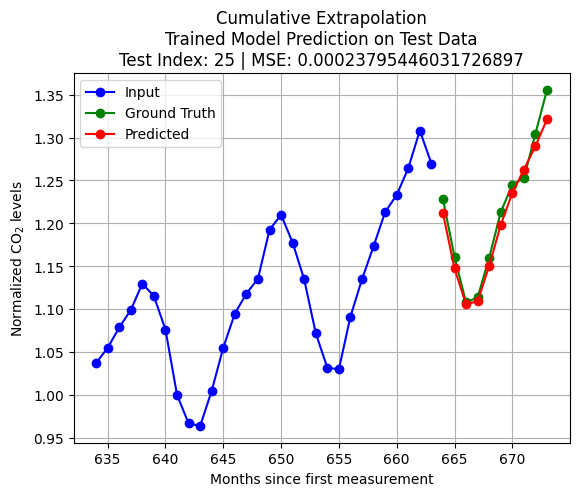

In [ ]:
train_size = 0.8
est2 = KTEstimator(scaled_D, K, T, train_size)
seed = 53
pred_len = 10

# Untrained Model Prediction
# est2.predict(model, seed, cumulative = True, pred_len = pred_len)

convergence = 1e-8
num_epochs = 2000
batch_size = 32
lr = 0.01
# Trained Model Prediction
est2.fit(model, convergence, num_epochs, batch_size, lr)
test_index = est2.predict(model, seed, cumulative = True, pred_len = pred_len)

In [ ]:

class TimeSeriesPredictor:
    def __init__(self, data, train_size, K, T):
        self.data = data
        self.train_size = train_size
        self.K = K  # Input feature length
        self.T = T  # Output predicted length
        self.X_train, self.X_test, self.y_train, self.y_test = self.split_data()

    def split_data(self):
        split_index = int(len(self.data) * self.train_size)
        X_train = self.data[:split_index]
        X_test = self.data[split_index:split_index + self.K]
        y_train = self.data[1:split_index + 1]
        y_test = self.data[split_index + 1:split_index + self.K + 1]
        return X_train, X_test, y_train, y_test

      def predict_arima(self, order, num_test_cases=5):
          for i in range(num_test_cases):
              model = ARIMA(self.X_train, order=order)
              model_fit = model.fit()
              forecast = model_fit.forecast(steps=self.T)
              test_index = np.random.randint(0, len(self.X_test) - self.T)

              forecast_length = len(forecast)  # Get the length of the forecast array

              plt.figure(figsize=(10, 6))
              plt.title(f'ARIMA Model Prediction\nTest Index: {test_index} | Order: {order}')
              plt.plot(range(test_index, test_index + self.K), self.X_test[test_index:test_index + self.K], 'bo-', label='Input')
              plt.plot(range(test_index + self.K, test_index + self.K + forecast_length), self.y_test[test_index:test_index + forecast_length], 'go-', label='Ground Truth')
              plt.plot(range(test_index + self.K, test_index + self.K + forecast_length), forecast, 'ro-', label='Predicted')
              plt.legend()
              plt.xlabel('Time')
              plt.ylabel('Value')
              plt.grid()
              plt.show()




    def predict_ma(self, q, num_test_cases=5):
        for i in range(num_test_cases):
            model = ARIMA(self.X_train, order=(0, 0, q))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=self.T)
            test_index = np.random.randint(0, len(self.X_test) - self.T)
            plt.title(f'MA Model Prediction\nTest Index: {test_index} | MA Order: {q}')
            plt.plot(range(test_index, test_index + self.K), self.X_test[test_index:test_index + self.K], 'bo-')
            plt.plot(range(test_index + self.K, test_index + self.K + self.T), self.y_test[test_index:test_index + self.T], 'go-')
            plt.plot(range(test_index + self.K, test_index + self.K + self.T), forecast, 'ro-')
            plt.legend(['Input', 'Ground Truth', 'Predicted'])
            plt.xlabel('Time')
            plt.ylabel('Value')
            plt.grid()
            plt.show()


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 17)

ValueError: x and y must have same first dimension, but have shapes (10,) and (9, 1)

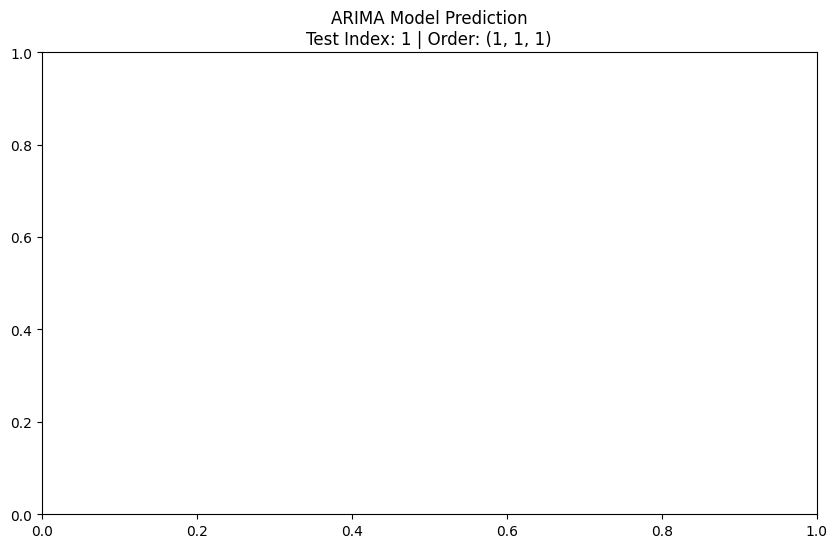

In [ ]:
predictor = TimeSeriesPredictor(scaled_D, train_size=0.8, K=10, T=5)
predictor.predict_arima(order=(1, 1, 1))  # ARIMA(1, 1, 1) model
predictor.predict_ma(q=3)  # MA(3) model


In [ ]:
# Plot the original data and the forecast
forecast = model_fit.forecast(steps=50)
y_test = scaled_D[int(len(scaled_D)*train_size)+K+test_index:int(len(scaled_D)*train_size)+K+pred_len+test_index]
loss = np.linalg.norm(y_test - forecast.to_numpy(),2)

plt.figure(figsize=(10, 6))
plt.plot(X_train, label='Original Data')
plt.plot(range(len(X_train), len(X_train) + len(forecast)), forecast, label='Forecast')
plt.legend()
plt.title('ARIMA Model Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

NameError: name 'model_fit' is not defined

In [5]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))
df = df[~df['year'].isin([1958, 2024])]
df

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
1959-01-01,1959,1,1959.0411,315.58,315.55,-1,-9.99,-0.99
1959-02-01,1959,2,1959.1260,316.48,315.86,-1,-9.99,-0.99
1959-03-01,1959,3,1959.2027,316.65,315.38,-1,-9.99,-0.99
1959-04-01,1959,4,1959.2877,317.72,315.41,-1,-9.99,-0.99
1959-05-01,1959,5,1959.3699,318.29,315.49,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
2023-08-01,2023,8,2023.6250,419.68,421.59,21,0.45,0.19
2023-09-01,2023,9,2023.7083,418.51,421.99,18,0.30,0.14
2023-10-01,2023,10,2023.7917,418.82,422.12,27,0.47,0.17
2023-11-01,2023,11,2023.8750,420.46,422.46,21,0.91,0.38


In [6]:
k = 3
t = 2

# Prepare input features (X) and target values (y) for the dfset
X = np.array([df['average'][i:(i + k)].values for i in range(len(df) - (k + t) + 1)]).reshape(-1, k)
y = np.array([df['average'][(i + k):(i + k + t)].values for i in range(len(df) - (k + t) + 1)]).reshape(-1, t)

# Display the shapes of X and y
X, X.shape, y.shape


(array([[315.58, 316.48, 316.65],
        [316.48, 316.65, 317.72],
        [316.65, 317.72, 318.29],
        ...,
        [423.68, 421.83, 419.68],
        [421.83, 419.68, 418.51],
        [419.68, 418.51, 418.82]]),
 (776, 3),
 (776, 2))

In [7]:
X_train = X[:611]
X_test = X[612:]

y_train = y[:611]
y_test = y[612:]

In [8]:
mlp_model = MLPRegressor(hidden_layer_sizes=[128, 256, 512, 256], max_iter = 10000)
mlp_model.fit(X_train, y_train)
y_hat_test = mlp_model.predict(X_test)

mse_mlp = mean_squared_error(y_test.flatten(), y_hat_test.flatten())
rmse_mlp = np.sqrt(mse_mlp)
rmse_mlp

2.553150905855876

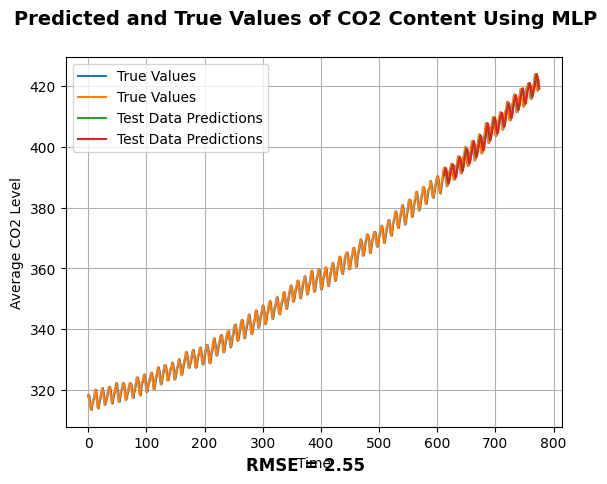

In [16]:
fig = plt.figure()
fig.suptitle('Predicted and True Values of CO2 Content Using MLP', fontsize=14, fontweight='bold')
plt.plot(range(len(y)), y, label='True Values')  # Plot true values
plt.plot(range(612, len(y)), y_hat_test, label='Test Data Predictions')  # Plot test data predictions
plt.legend()
plt.xlabel('Time')
plt.ylabel('Average CO2 Level')
fig.text(0.5, 0.02, f'RMSE = {rmse_mlp:.2f}', ha='center', fontsize=12, fontweight='bold')  # Display RMSE
plt.grid(True)  # Added grid for better readability
plt.show()


In [10]:
# Initialize an empty array for the MA model predictions
y_test_pred_ma = np.empty_like(y_test)

# Fit an MA model for each feature in the test data
for i in range(y_test.shape[1]):
    model = ARIMA(y_test[:, i], order=(0, 0, 1))  # MA(1) model
    model_fit = model.fit()
    y_test_pred_ma[:, i] = model_fit.predict(start=0, end=y_test.shape[0] - 1)

# Calculate the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse_ma = mean_squared_error(y_test.flatten(), y_test_pred_ma.flatten())
rmse_ma = np.sqrt(mse_ma)
print(f"RMSE (MA model): {rmse_ma}")

# Display the predictions made by the MA model
y_test_pred_ma


RMSE (MA model): 5.221643828381276


array([[405.47159334, 405.69561029],
       [399.0707986 , 399.45296519],
       [401.56439624, 400.98050164],
       [398.58330101, 397.76820829],
       [398.93295845, 398.31361142],
       [396.81080421, 396.29348458],
       [397.08805783, 398.09918167],
       [397.02080549, 397.62111127],
       [398.2264453 , 398.91338544],
       [398.05880674, 399.02464634],
       [399.50905435, 399.3561601 ],
       [398.63414267, 399.6869775 ],
       [400.08624442, 399.93040074],
       [399.30009742, 400.57070583],
       [400.90751572, 399.51781501],
       [398.94894268, 399.32434547],
       [399.60907851, 397.23272877],
       [396.70805004, 398.18694369],
       [398.43451949, 397.17488151],
       [396.68933427, 399.33758956],
       [399.55796603, 398.76699726],
       [398.31447489, 400.48856918],
       [400.68472598, 399.52978125],
       [399.10376104, 400.96355076],
       [401.13840409, 401.29724002],
       [400.89622826, 401.49816683],
       [401.65228278, 400.31684358],
 

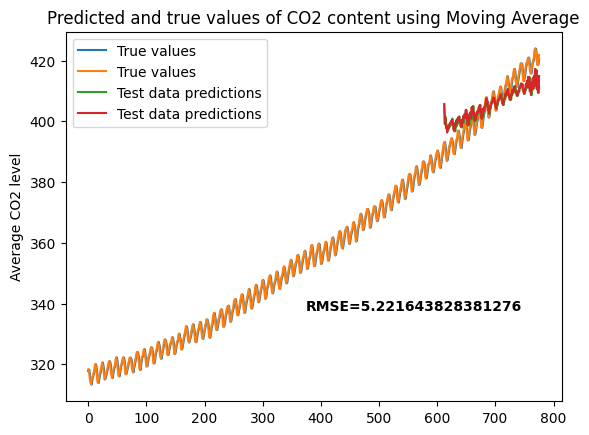

In [11]:
fig = plt.figure()
fig.text(0.5, 0.3, f'RMSE={rmse_ma}', weight='bold')
plt.plot(range(len(y)), y, label='True values')
plt.plot(range(612, len(y)), y_test_pred_ma, label='Test data predictions')
plt.legend()
plt.xlabel('')
plt.ylabel('Average CO2 level')
plt.title('Predicted and true values of CO2 content using Moving Average')
plt.show()

In [12]:
# Prepare an array to hold the ARMA model predictions
y_test_pred_arma = np.zeros(y_test.shape)

# Iterate over each column in the test dataset
for i in range(y_test.shape[1]):
    # Fit an ARMA(1,1) model to the current column
    arma_model = ARIMA(y_test[:, i], order=(1, 0, 1))
    fitted_model = arma_model.fit()
    # Store the predictions in the corresponding column of the predictions array
    y_test_pred_arma[:, i] = fitted_model.predict(start=0, end=y_test.shape[0] - 1)

# Calculate the RMSE for the ARMA model predictions
arma_mse = mean_squared_error(y_test.ravel(), y_test_pred_arma.ravel())
arma_rmse = np.sqrt(arma_mse)
print(f"ARMA Model RMSE: {arma_rmse}")

# Display the ARMA model predictions
y_test_pred_arma


ARMA Model RMSE: 1.4690195243884452


array([[406.18734368, 406.8077302 ],
       [392.74129621, 393.28063036],
       [393.55345786, 392.11368058],
       [391.84874028, 389.59963724],
       [389.68842423, 388.07271242],
       [387.99687458, 386.57171868],
       [386.60995533, 388.16562521],
       [388.14029237, 389.49562471],
       [389.5090852 , 390.47146857],
       [390.45949492, 392.30722554],
       [392.31128069, 392.03211326],
       [392.02549695, 393.42838253],
       [393.42863638, 393.57977349],
       [393.57542304, 395.06222696],
       [395.06078002, 393.3680003 ],
       [393.3645014 , 392.44623543],
       [392.44429864, 389.14354035],
       [389.14077316, 389.54058277],
       [389.53881352, 389.14086477],
       [389.13840639, 391.49570179],
       [391.4937155 , 392.56590798],
       [392.56327299, 393.91819345],
       [393.91580526, 394.24410524],
       [394.24136306, 394.93157054],
       [394.92900042, 397.40698309],
       [397.40417914, 396.72361348],
       [396.72061227, 395.49902873],
 

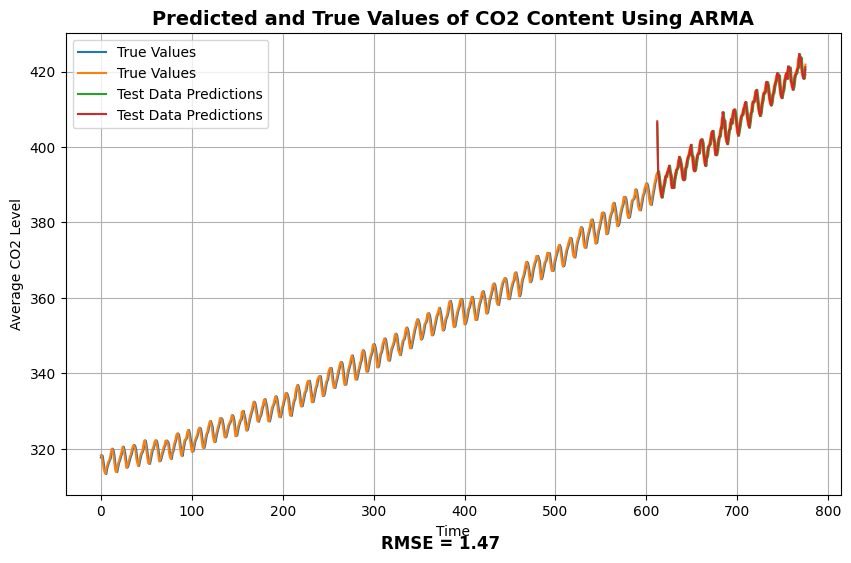

In [14]:

plt.figure(figsize=(10, 6))
plt.plot(range(len(y)), y, label='True Values')
plt.plot(range(612, len(y)), y_test_pred_arma, label='Test Data Predictions')
plt.title('Predicted and True Values of CO2 Content Using ARMA', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Average CO2 Level')
plt.legend()
plt.figtext(0.5, 0.02, f'RMSE = {arma_rmse:.2f}', ha='center', fontsize=12, fontweight='bold')
plt.grid()
plt.show()


The comparative analysis of the RMSE (Root Mean Square Error) values indicates that the ARMA (Auto Regressive Moving Average) model outperforms the other models in terms of prediction accuracy, as evidenced by its lowest RMSE value. In contrast, the MA (Moving Average) model exhibits the highest RMSE value, indicating a less accurate fit to the data. The RMSE value for the MLP (Multi-Layer Perceptron) model falls between those of the ARMA and MA models.

The superior performance of the ARMA model can be attributed to its ability to leverage both the past values of the series and the moving average of the error terms. This dual consideration allows the ARMA model to capture more complex temporal dynamics compared to the MA model, which relies solely on the moving average of the error terms.

On the other hand, the performance of the MLP model is heavily dependent on the chosen network parameters, such as the number of layers, neurons, and the learning rate. As a result, the RMSE value for the MLP model cannot be generalized to always be greater or lesser than those of the ARMA and MA models. It is contingent upon the specific configuration of the neural network and its ability to capture the underlying patterns in the data.